In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import defaultdict
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/BlackFriday.csv')

In [3]:
data.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [4]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
data.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64

In [6]:
data.shape

(537577, 12)

In [7]:
data.drop(['User_ID', 'Product_Category_2', 'Product_Category_3'], axis = 1, inplace = True)

In [8]:
data.head()

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase
0,P00069042,F,0-17,10,A,2,0,3,8370
1,P00248942,F,0-17,10,A,2,0,1,15200
2,P00087842,F,0-17,10,A,2,0,12,1422
3,P00085442,F,0-17,10,A,2,0,12,1057
4,P00285442,M,55+,16,C,4+,0,8,7969


In [9]:
label_dict = defaultdict(LabelEncoder)
data[['Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1']] = data[['Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1']].apply(lambda x: label_dict[x.name].fit_transform(x))

In [10]:
X = data
y = X.pop('Purchase')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

In [12]:
cat_cols_dict = {col: list(data[col].unique()) for col in ['Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1']}

In [13]:
train_input_list = []
test_input_list = []

for col in cat_cols_dict.keys():
    raw_values = np.unique(data[col])
    value_map = {}
    for i in range(len(raw_values)):
        value_map[raw_values[i]] = i       
    train_input_list.append(X_train[col].map(value_map).values)
    test_input_list.append(X_test[col].map(value_map).fillna(0).values)

In [19]:
cols_out_dict = {
    'Product_ID': 20,
    'Gender': 1,
    'Age': 2,
    'Occupation': 6,
    'City_Category': 1,
    'Stay_In_Current_City_Years': 2,
    'Marital_Status': 1,
    'Product_Category_1': 9
}

In [20]:
inputs = []
embeddings = []

for col in cat_cols_dict.keys():
    
    inp = Input(shape=(1,), name = 'input_' + col)
    embedding = Embedding(len(cat_cols_dict[col]), cols_out_dict[col], input_length=1, name = 'embedding_' + col)(inp)
    embedding = Reshape(target_shape=(cols_out_dict[col],))(embedding)
    inputs.append(inp)
    embeddings.append(embedding)


x = Concatenate()(embeddings)
x = Dense(4, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Dense(2, activation='relu')(x)
output = Dense(1, activation='relu')(x)

model = Model(inputs, output)

model.compile(loss='mse', optimizer='adam')

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_Product_ID (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
input_Gender (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
input_Age (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_Occupation (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
input_City

In [22]:
model.fit(train_input_list, y_train, validation_data = (test_input_list, y_test), epochs=20, batch_size=128)

Train on 376303 samples, validate on 161274 samples
Epoch 1/20
376303/376303 [==============================] - 10s 27us/step - loss: 30156453.6691 - val_loss: 7394723.5614
Epoch 2/20
376303/376303 [==============================] - 9s 25us/step - loss: 7205323.2675 - val_loss: 7178044.9611
Epoch 3/20
376303/376303 [==============================] - 10s 26us/step - loss: 7111668.2956 - val_loss: 7154959.3399
Epoch 4/20
376303/376303 [==============================] - 10s 26us/step - loss: 7091268.6996 - val_loss: 7150854.1839
Epoch 5/20
376303/376303 [==============================] - 10s 26us/step - loss: 7083904.7947 - val_loss: 7146774.0689
Epoch 6/20
376303/376303 [==============================] - 10s 27us/step - loss: 7081084.6969 - val_loss: 7147240.9942
Epoch 7/20
376303/376303 [==============================] - 10s 25us/step - loss: 7077895.8195 - val_loss: 7149531.1135
Epoch 8/20
376303/376303 [==============================] - 10s 26us/step - loss: 7076351.1884 - val_loss: 7

In [24]:
model.evaluate(test_input_list, y_test)

161274/161274 [==============================] - 4s 26us/step


7149406.392772549

In [25]:
embedding_Occupation = model.get_layer('embedding_Occupation').get_weights()[0]
embedding_Product_ID = model.get_layer('embedding_Product_ID').get_weights()[0]
embedding_Product_Category_1 = model.get_layer('embedding_Product_Category_1').get_weights()[0]

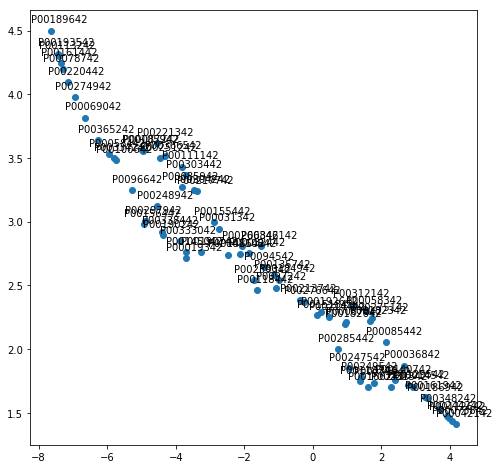

In [32]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(embedding_Product_ID[:75])
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(label_dict['Product_ID'].inverse_transform(cat_cols_dict['Product_ID'])[:75]):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
plt.show()

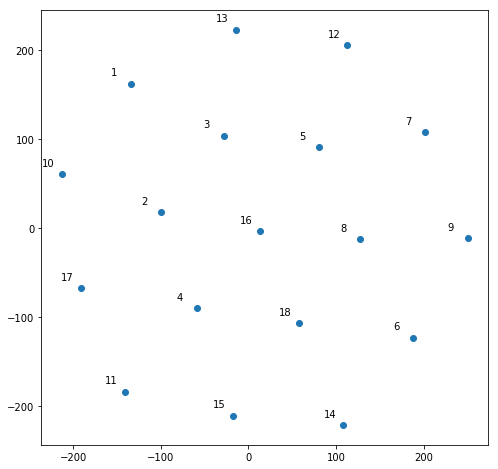

In [27]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(embedding_Product_Category_1)
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(label_dict['Product_Category_1'].inverse_transform(cat_cols_dict['Product_Category_1'])):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
plt.show()

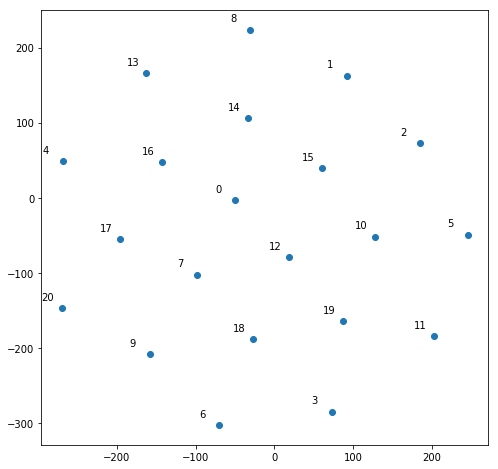

In [28]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(embedding_Occupation)
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(label_dict['Occupation'].inverse_transform(cat_cols_dict['Occupation'])):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
plt.show()

In [52]:
model.save ('black-friday.model')